In [3]:
%load_ext autoreload

# Set autoreload to update modules automatically before executing code
%autoreload 2
from envs.cartpole import Cartpole
from controllers.constant import target
from controllers.QP import QP_CBF_controller
from filters.disc import disc
from inv_set.cartpole import trap
from filters.NN_filters import FCN
from inv_set.inv_ped import cbf
import numpy as np
import matplotlib.pyplot as plt
import torch 
inv_set = trap(0.5, -5)
disc_steps = 2
env = Cartpole(inv_set, disc_steps)
input_size = 4
output_size = 2
n_layers = 5
size=1000
activation = 'relu'
lr = 5e-4
sc = 1
gamma_pos = 1
gamma_neg = 5
nn_filter = FCN(input_size, output_size, n_layers, size, activation, lr, sc, gamma_pos, gamma_neg)
checkpoint = torch.load('exps/cartpole/model.pth', map_location=torch.device('cpu'))
nn_filter.FCN.load_state_dict(checkpoint['model_state_dict'])
nn_filter.FCN.eval()

/home/artur/miniconda3/envs/fsrl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/artur/miniconda3/envs/fsrl/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Sequential(
  (0): Linear(in_features=4, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=1000, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1000, out_features=1000, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1000, out_features=1000, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1000, out_features=1000, bias=True)
  (9): ReLU()
  (10): Linear(in_features=1000, out_features=2, bias=True)
  (11): Identity()
)

In [6]:
nn_filter.forward([0,0,0,0])

(tensor([[-0.0020]], grad_fn=<SliceBackward0>),
 tensor([-0.0069], grad_fn=<SelectBackward0>))

In [103]:

from torch.distributions.uniform import Uniform
import random
def actor(state):
    nn_filter.FCN.eval()
    a_h,b_h = nn_filter.forward(state)
    a = Uniform(-1, 1).sample().unsqueeze(dim=0)
    if a_h @ a < b_h:
        a = a - (((a_h @ a) - b_h) / torch.norm(a, dim=-1)) * a_h
    return a, a_h, b_h


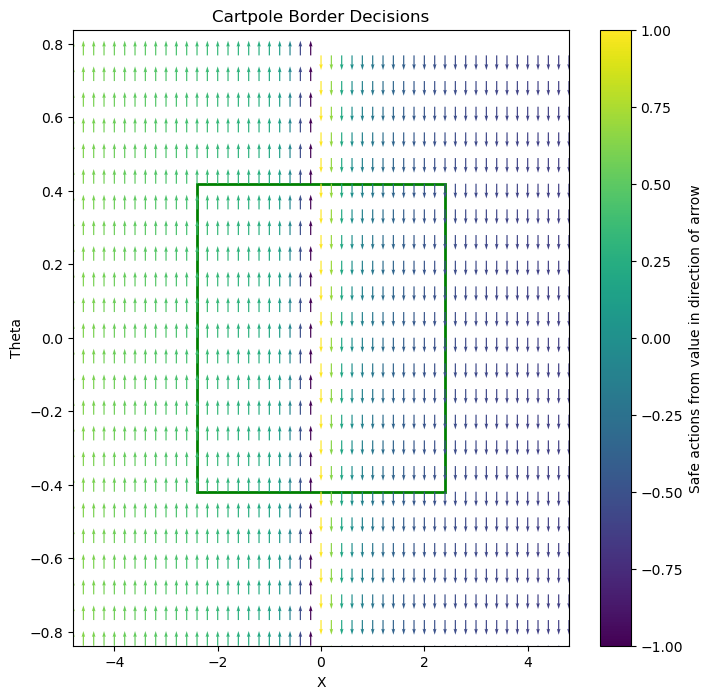

In [105]:
#Plot the hyperplanes in safe direction for all states
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
safe_radians = 24 * 2 * math.pi / 360
borders = []
arrowDirX=[]
arrowDirY=[]
safe_x=2.4
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
colors = []
for x in np.arange(-2.4-2.4,2.5+2.4,0.2):
    for theta in np.arange(-safe_radians*2,safe_radians*2,math.pi / 360 *8):
        o=[x,0,theta,0]
        a, a_h, b_h = actor(o)
        borders.append([x,theta])
        a_h = a_h.detach().numpy()
        b_h = b_h.detach().numpy()
        threshold = np.clip((b_h/a_h),-1,1)
        if(a_h>0):
            to_right_is_dangerous = False
        else:
            to_right_is_dangerous = True
        if to_right_is_dangerous:
            arrowDirX.append(0)
            arrowDirY.append(-1)
            colors.append(threshold)
        else:
            arrowDirX.append(0)
            arrowDirY.append(1)
            colors.append(threshold)
borders = np.array(borders)
rectangle = patches.Rectangle((-safe_x, -safe_radians), 2*safe_x, 2*safe_radians, linewidth=2, edgecolor='green', facecolor='white')
ax.add_patch(rectangle)
quiver_plot=plt.quiver(borders[:,0], borders[:,1], arrowDirX, arrowDirY,colors, cmap ="viridis", angles='xy', scale_units='xy', scale=25)
# This are the borders of the simulation
plt.axis([-2*safe_x, 2*safe_x, -2*safe_radians, 2*safe_radians])
plt.colorbar(quiver_plot, label="Safe actions from value in direction of arrow")            
plt.xlabel("X")
plt.ylabel("Theta")
plt.title("Cartpole Border Decisions")
plt.show()

In [111]:
import time
import numpy as np
borders=[]
colors=[]
for x in np.arange(-2.4-1.2,2.5+1.2,0.4):
    for theta in np.arange(-safe_radians*1.5,safe_radians*1.5,math.pi / 360 *16):
        print(x)
        print(theta)
        o = env.reset([x,0,theta,0])
        steps = 0
        done = False
        while not done and steps <=1000:
            a, a_h, b_h = actor(o)
            a_h = a_h.detach().numpy()
            b_h = b_h.detach().numpy()
            a = a.detach().numpy()
            threshold = np.clip((b_h/a_h)[0],-1,1)
            next_o, r, d, info = env.step(a)
            done = d
            steps +=1
            print(a)
            print(o)
            o = next_o
        borders.append([x,theta])
        if done: 
            colors.append(0)
        else:
            colors.append(1)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
borders = np.array(borders)
safe_x = 2.4
safe_radians = 24 * 2 * math.pi / 360
rectangle = patches.Rectangle((-safe_x, -safe_radians), 2*safe_x, 2*safe_radians, linewidth=2, edgecolor='green', facecolor='white')
ax.add_patch(rectangle)
scatter_plot=plt.scatter(borders[:,0], borders[:,1],c= colors, cmap="viridis")
# This are the borders of the simulation
plt.axis([-2*safe_x, 2*safe_x, -2*safe_radians, 2*safe_radians])
plt.colorbar(scatter_plot, label="Stabilized or not")            
plt.xlabel("X")
plt.ylabel("Theta")
plt.title("Cartpole Border Decisions")
plt.show()  # Close plot to avoid replotting issues

-3.5999999999999996
-0.6283185307179586


AssertionError: array([[0.05499543]], dtype=float32) (<class 'numpy.ndarray'>) invalid